In [2]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from duke_dbt_data import dcmread_image

In [3]:
df = pd.read_csv("/media/omar/Elements/BC-data/BCS-DBT file-paths-train-v2 (copy).csv")

In [92]:
df.to_csv('your.csv', index=False)

In [4]:
view_series = df.iloc[0]
view = view_series["View"]
# if you have image data saved in classic path folder structure, read the file path from "classic_path"
# image_path = os.path.join("/data", view_series["classic_path"])
image_path = os.path.join("/media/omar/Elements/BC-data/manifest-1617905855234", view_series["descriptive_path"])

In [45]:

image = dcmread_image(fp=image_path, view=view)

C:\Users\omare\Anaconda3\envs\myenv\lib\site-packages\openjpeg\utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


In [46]:
print(image)

dtype('uint16')

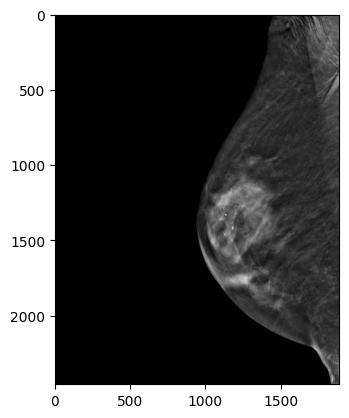

In [5]:
plt.imshow(image[0], cmap=plt.cm.gray);

In [5]:
#this stacks the images in a 5d array but using all the memory at once
import os
import numpy as np
from skimage.transform import resize
from duke_dbt_data import dcmread_image


directory_path = "/media/omar/Elements/BC-data/manifest-1617905855234"


images = []

# looping through the rows to read in the images
for index, row in df.head(10).iterrows():
    # get image path
    image_path = os.path.join(directory_path, row["descriptive_path"])

    # read in image and resize
    view_series = df.iloc[index]
    view = view_series["View"]
    image = dcmread_image(fp=image_path, view=view)
    resized_image = resize(image, (10, 300,300))  # resize to (256, 256) shape
    images.append(resized_image)

# convert list of images to 4D numpy array adding the one so that they are greyscaled as seen by the sytem
images_array = np.stack(images)
images_array = images_array.reshape(images_array.shape + (1,))


# checks shape of array
print(images_array.shape)




/home/omar/anaconda3/envs/tensor/lib/python3.10/site-packages/openjpeg/utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


(10, 10, 300, 300, 1)


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


C:\Users\omare\Anaconda3\envs\myenv\lib\site-packages\openjpeg\utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


(2, 10, 300, 300, 1)


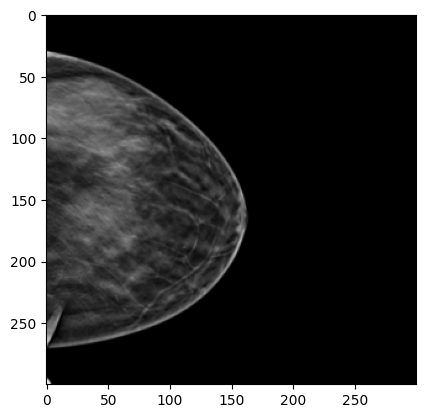

In [25]:
#this stacks the images but doesnt use all the memory at once and goes through the batch method
import os
import numpy as np
from skimage.transform import resize
from duke_dbt_data import dcmread_image

# defining path to directory containing DICOM images
directory_path = "/media/omar/Elements/BC-data/manifest-1617905855234"
df = pd.read_csv("/media/omar/Elements/BC-data/BCS-DBT file-paths-train-v2 (copy).csv")

# using generator to deal with images on a batch level where we are not taking up all the memory 
def image_generator(batch_size):
    while True:
        # empty list for images
        images = []

        # loop through the rows to read in the images
        for index, row in df.head(batch_size).iterrows():
            # get image path
            image_path = os.path.join(directory_path, row["descriptive_path"])

            # read in image and resize
            view_series = df.iloc[index]
            view = view_series["View"]
            image = dcmread_image(fp=image_path, view=view)
            plt.imshow(image[0], cmap=plt.cm.gray);
            resized_image = resize(image, (10, 300,300))  # resize to (256, 256) shape
            plt.imshow(resized_image[0], cmap=plt.cm.gray);
            images.append(resized_image)

        # convert list of images to 4D numpy array for greyscaling
        images_array = np.stack(images)
        images_array = images_array.reshape(images_array.shape + (1,))

        
        yield images_array

# creating a generator object
batch_size = 2
image_gen = image_generator(batch_size)

# getting first batch which will be only batch
batch_images = next(image_gen)
print(batch_images.shape)


croppign in with too little slices from 10 to 40 was too much and removes detail from the image , 20 slices may be better and maybe 512 by 512 for resoltuion

C:\Users\omare\Anaconda3\envs\myenv\lib\site-packages\openjpeg\utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


(1, 10, 300, 300, 1)


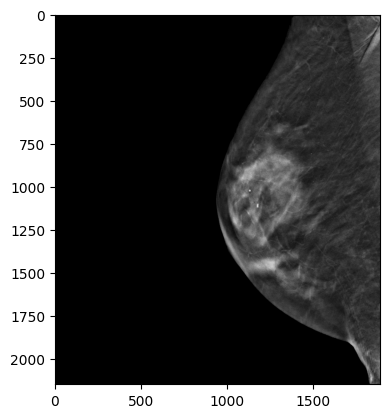

In [41]:
import os
import numpy as np
from skimage.transform import resize
from duke_dbt_data import dcmread_image

# defining path to directory containing DICOM images
directory_path = "/media/omar/Elements/BC-data/manifest-1617905855234"
df = pd.read_csv("/media/omar/Elements/BC-data/BCS-DBT file-paths-train-v2 (copy).csv")

# using generator to deal with images on a batch level where we are not taking up all the memory 
def image_generator(batch_size):
    while True:
        # empty list for images
        images = []

        # loop through the rows to read in the images
        for index, row in df.head(batch_size).iterrows():
            # get image path
            image_path = os.path.join(directory_path, row["descriptive_path"])

            # read in image and slice to remove one-third of the width
            view_series = df.iloc[index]
            view = view_series["View"]
            image = dcmread_image(fp=image_path, view=view)
            image = image[:, image.shape[1]//8:, :]  # remove one-third of the width
            plt.imshow(image[0], cmap=plt.cm.gray);

            # resize image
            resized_image = resize(image, (10, 300, 300))  # resize to (300, 300) shape


            # append resized image to list of images
            images.append(resized_image)

        # convert list of images to 4D numpy array
        images_array = np.stack(images)
        images_array = images_array.reshape(images_array.shape + (1,))

        # yield batch of images
        yield images_array

# create a generator object
batch_size = 10
image_gen = image_generator(batch_size)

# example usage: get first batch of images
batch_images = next(image_gen)
print(batch_images.shape)


/home/omar/anaconda3/envs/tensor/lib/python3.10/site-packages/openjpeg/utils.py:209: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


(1, 20, 512, 512, 1)


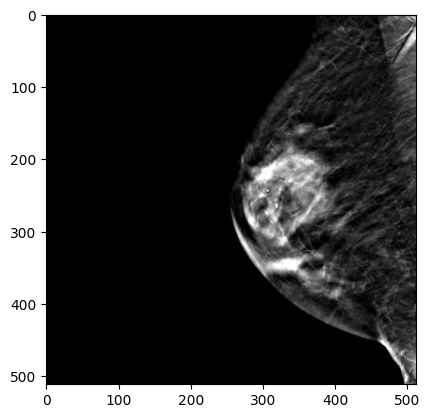

In [12]:
import os
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from duke_dbt_data import dcmread_image


directory_path = "/media/omar/Elements/BC-data/manifest-1617905855234"
df = pd.read_csv("/media/omar/Elements/BC-data/BCS-DBT file-paths-train-v2 (copy).csv")

# using truncation normalization function to exenuate tumour from previous mamography pre processor 
def truncation_normalization(img, mask):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    @mask : numpy array mask of the breast
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

# using generator to deal with images on a batch level where we are not taking up all the memory 
def image_generator(batch_size):
    while True:
        
        images = []

        # looping through the rows to read in the images
        for index, row in df.head(batch_size).iterrows():
            # get image path
            image_path = os.path.join(directory_path, row["descriptive_path"])

            # removing one eights of the width to remove black parts as removing more will corrupt image
            view_series = df.iloc[index]
            view = view_series["View"]
            image = dcmread_image(fp=image_path, view=view)
            image = image[:, image.shape[1]//8:, :]  # remove one-third of the width

            # normalization of the image using the fucntion
            mask = np.zeros_like(image)
            mask[image > 0] = 1  # create a mask of the breast region
            normalized_image = truncation_normalization(image, mask)
            plt.imshow(normalized_image[0], cmap=plt.cm.gray);

            # resize image
            resized_image = resize(normalized_image, (20, 512, 512))  # resize to (300, 300) shape

            # append resized image to list of images
            images.append(resized_image)
            plt.imshow(resized_image[0], cmap=plt.cm.gray);


        # convert list of images to 4D numpy array
        images_array = np.stack(images)
        images_array = images_array.reshape(images_array.shape + (1,))

        # yield batch of images
        yield images_array

# creating a generator object
batch_size = 1
image_gen = image_generator(batch_size)

# loading in batcher of images 
batch_images = next(image_gen)
print(batch_images.shape)


After going thoruhg the previous iteration I concluded that 512 by 512 was an effective enough resolution to get detail from the image. Truncation noramlization was very useful it emphasising the tumour more. Here we can also see the striation more after normalization. This shows striation more and puts durther emphasis upon the tumour

However for now given that I only have 8gb avaliable on my personal gpu I will test on 10 ,300,300 so array can be loaded into ram

In [37]:
print(batch_images)

[[[[[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.5523122 ]
    [0.64338287]
    [0.65855865]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.62004799]
    [0.66354704]
    [0.55322877]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.74981687]
    [0.75205565]
    [0.67759147]]

   ...

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.23994018]
    [0.21025641]
    [0.16509078]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.32452547]
    [0.28341923]
    [0.25370754]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.38418931]
    [0.29465203]
    [0.26504118]]]


  [[[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.55529874]
    [0.61120925]
    [0.6362238 ]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.61181584]
    [0.71306384]
    [0.65239866]]

   [[0.        ]
    [0.        ]
    [0.        ]
    ...
    [0.72366756]
    [0.7504575 ]
 

This keras based neural neetwork will have more layers and will inlcude the greater amount of labels found in the 20,000 images 

In [11]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# converting the labels of cancer to one hot encoded numbers 
labels = np.array([2, 1, 1, 1, 1])

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(batch_images, labels, test_size=0.2, random_state=42)

# normalize pixel values
X_train = X_train.astype('float32') / 65535.0
X_val = X_val.astype('float32') / 65535.0

# define CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),
    tf.keras.layers.Conv3D(64, kernel_size=(3,3,3), activation='relu'),
    tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# compile the model with binary_crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, batch_size=5, epochs=2, validation_data=(X_val, y_val))

# evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val)

print('Test accuracy:', test_acc)




2023-03-29 13:03:07.463709: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 166.53MiB (rounded to 174620672)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-03-29 13:03:07.463782: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-03-29 13:03:07.463803: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 45, Chunks in use: 45. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 2.1KiB client-requested in use in bin.
2023-03-29 13:03:07.463815: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 6, Chunks in use: 6. 3.2KiB allocated for chunks. 3.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2023-03-29 13:03:07.463826: I tensorflow/

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[341056,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]